# Predicticing Diagnosis of Pancriatic Cancer from Urinary Biomarkers

In [2]:
#Imports 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from scipy.stats import f_oneway
from sklearn.model_selection import GroupShuffleSplit
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, recall_score, f1_score, precision_score
from catboost import CatBoostClassifier
from matplotlib.colors import LinearSegmentedColormap
from xgboost import XGBClassifier
import lime
from lime import lime_tabular
import shap

In [3]:
custom_cmap = LinearSegmentedColormap.from_list("adjusted_heatmap", ['#f3f0ff', '#d0bdf4', '#f3a683', '#e78ea9'])

## 1. Data Preprocessing

### 1.1 Data Profiling

#### 1.1.1 Data Overview 
In order to view the dataset, to understand and develop a model; The data is first loaded into a dataframe and inspected. Here the columns are viewed to give insight into the features that can be used for our classification model. 

In [6]:
#load into pandas df
df = pd.read_csv('pancreatic_c.csv')
#view the columns in the dataset
print(df.columns.tolist())

['sample_id', 'patient_cohort', 'sample_origin', 'age', 'sex', 'diagnosis', 'stage', 'benign_sample_diagnosis', 'plasma_CA19_9', 'creatinine', 'LYVE1', 'REG1B', 'TFF1', 'REG1A']


In this dataset we have: 
1. Sample Information: 'sample_id', 'patient_cohort', 'sample_origin',
2. Demographic Information: 'age', 'sex',
3. Diagnosis and Stage: 'diagnosis', 'stage', 'benign_sample_diagnosis'
4. Biomarkers: 'plasma_CA19_9', 'creatinine', 'LYVE1', 'REG1B', 'TFF1', 'REG1A'

We will be viewing the dataset through multiple means to observe the different types of data available within this dataset: 

Firstly

In [10]:
df.info() #information about the data

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 590 entries, 0 to 589
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   sample_id                590 non-null    object 
 1   patient_cohort           590 non-null    object 
 2   sample_origin            590 non-null    object 
 3   age                      590 non-null    int64  
 4   sex                      590 non-null    object 
 5   diagnosis                590 non-null    int64  
 6   stage                    199 non-null    object 
 7   benign_sample_diagnosis  208 non-null    object 
 8   plasma_CA19_9            350 non-null    float64
 9   creatinine               590 non-null    float64
 10  LYVE1                    590 non-null    float64
 11  REG1B                    590 non-null    float64
 12  TFF1                     590 non-null    float64
 13  REG1A                    306 non-null    float64
dtypes: float64(6), int64(2), o

In [11]:
df.describe() #mean, std etc for numerical items

,age,diagnosis,plasma_CA19_9,creatinine,LYVE1,REG1B,TFF1,REG1A
count,590.000000,590.000000,350.000000,590.000000,590.000000,590.000000,590.000000,306.000000
mean,59.079661,2.027119,654.002944,0.855383,3.063530,111.774090,597.868722,735.281222
std,13.109520,0.804873,2430.317642,0.639028,3.438796,196.267110,1010.477245,1477.247724
min,26.000000,1.000000,0.000000,0.056550,0.000129,0.001104,0.005293,0.000000
25%,50.000000,1.000000,8.000000,0.373230,0.167179,10.757216,43.961000,80.692000
50%,60.000000,2.000000,26.500000,0.723840,1.649862,34.303353,259.873974,208.538500
75%,69.000000,3.000000,294.000000,1.139482,5.205037,122.741013,742.736000,649.000000
max,89.000000,3.000000,31000.000000,4.116840,23.890323,1403.897600,13344.300000,13200.000000


#### 1.1.2 Summary Statistics

##### 1.1.2a Age Distribution of Sample

<Axes: xlabel='age', ylabel='Count'>

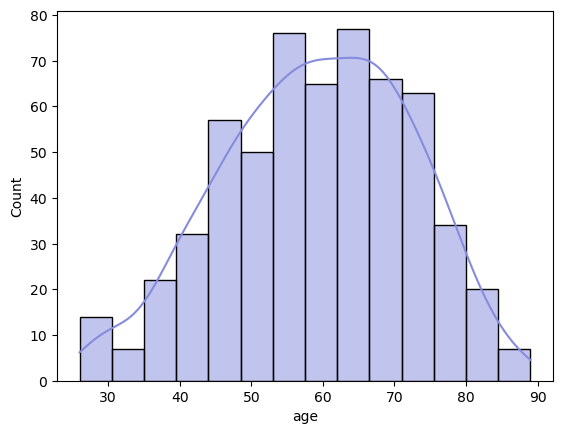

In [13]:
# view age distrubution of sample
sns.histplot(df['age'], color='#858cdd', kde=True)

The age distribution follows a normal distribution

##### 1.1.2b Gender Distribution of Sample

<Axes: xlabel='sex', ylabel='count'>

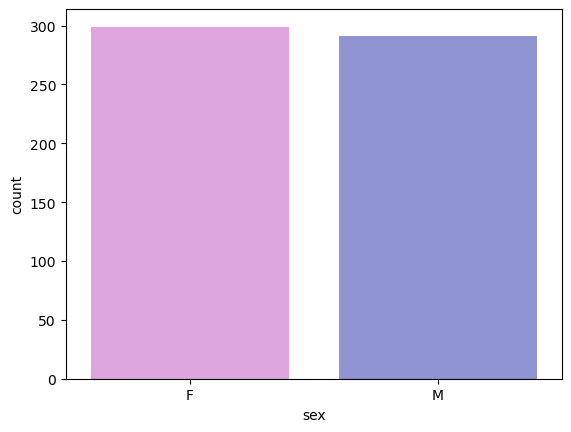

In [16]:
#view sex distribution of sample
genders=['#e79ce8','#858cdd']
sns.countplot(x='sex', hue='sex', data=df, palette=genders)#, legend=False)

There are slightly more females than males, but relatively balanced.

##### 1.1.2c Distribution of Sample Origin (Healthy control, Non-cancer, Cancer)

In [19]:
df['diagnosis'].value_counts()

diagnosis
2    208
3    199
1    183
Name: count, dtype: int64

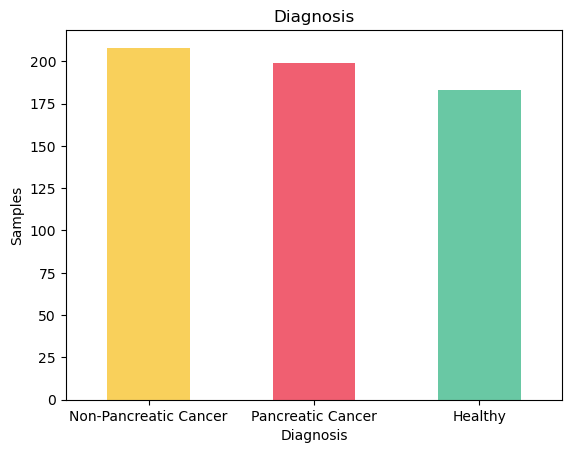

In [20]:
#distribution of samples (control, non-cancer, cancer)
diagnosis_counts = df['diagnosis'].value_counts()
diagnosis_counts.index = diagnosis_counts.index.map({1: 'Healthy', 2: 'Non-Pancreatic Cancer',3:'Pancreatic Cancer'})
traffic_light = ['#f9d05b', '#f05f71', '#69c8a4']
diagnosis_counts.plot(kind='bar',color=traffic_light)
plt.title("Diagnosis")
plt.xlabel("Diagnosis")
plt.ylabel("Samples")
plt.xticks(rotation=0)
plt.show()

The distribution between the three classes are fairly balanced. This is good for the model development.

##### 1.1.2d Distribution of Sample Origin

<Axes: xlabel='sample_origin', ylabel='count'>

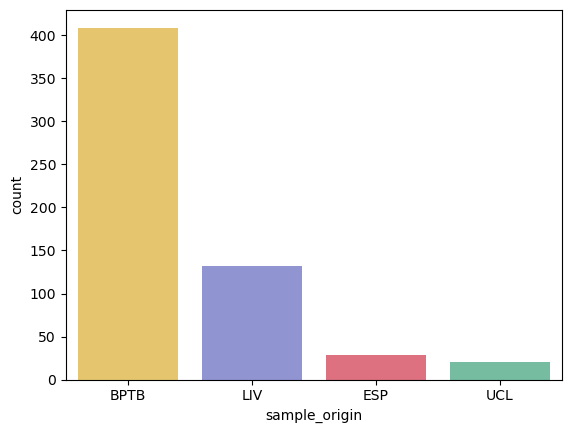

In [23]:
#distribution of sample origin
origins = ['#f9d05b', '#858cdd', '#f05f71', '#69c8a4']
sns.countplot(x='sample_origin',hue='sample_origin', data=df, palette=origins)#,legend=False)

As we can see from the bar graph, the samples are majoritily taken from one center. While there could be some influencing factors on the center of origin and pancreatic cancer outcome, they are not relevant to biomarkers and other factors. Furthermore, when viewing the diagnosis breakdown: 

In [25]:
df.groupby('sample_origin')['diagnosis'].value_counts()

sample_origin  diagnosis
BPTB           1            183
               2            143
               3             83
ESP            3             23
               2              6
LIV            3             93
               2             39
UCL            2             20
Name: count, dtype: int64

In the diagnosis breakdown, there is a large imbalance in the distribution of diagnosis classifications across sample origin centers. For example, all healthy controls come from the BPTB center, while the UCL center includes only non-cancer controls. This pattern likely reflects sampling based on availability or study design constraints, rather than the true prevalence of pancreatic cancer. As such, sample origin should not be considered a meaningful predictive feature. Including it in the model may introduce a confounding variable, leading to overfitting and reduced generalizability afterwards. Moreover, as origin is indirectly associated with the diagnosis due to a type of selection bias, its inclusion may cause data leakage.

##### 1.1.2e Viewing the benign sample diagnosis

In [28]:
#view unique values in diagnosis, non-PC 
df.groupby('benign_sample_diagnosis').size().sort_values(ascending=False)

benign_sample_diagnosis
Pancreatitis                                                    41
Pancreatitis (Chronic)                                          35
Gallstones                                                      21
Pancreatitis (Alcohol-Chronic)                                  11
Cholecystitis                                                    9
Serous cystadenoma - NOS                                         7
Choledocholiathiasis                                             6
Abdominal Pain                                                   6
Pancreatitis (Alcohol-Chronic-Pseuodcyst)                        4
Pancreatitis (Pseudocyst)                                        4
Pancreatitis (Idiopathic)                                        4
Pancreatitis (Gallstone)                                         4
Gallstones - Incidental                                          3
Cholecystitis (Chronic)                                          3
Pancreatitis (Autoimmune)             

There are many different diagnosis, to narrow this down they will be grouped. 

In [30]:
def categorize_diagnosis(diagnosis):
    if pd.isna(diagnosis) or str(diagnosis).strip() == "":
        return ""

    d = str(diagnosis).lower()
    
    if "pancreatitis" in d:
        return "Pancreatitis"
    elif any(term in d for term in ["gallstone", "cholecystitis", "gallbladder", "cholelithiasis"]):
        return "Gallbladder"
    elif any(term in d for term in ["choledocho", "biliary", "stricture", "anastomoses", "cyst"]):
        return "Biliary"
    elif any(term in d for term in ["gastritis","reflux","duodenum","duodenal","abdominal pain","abdominal"]):
        return "Gastrointestinal"
    else:
        return "Other"

# Create the new column
df['Benign_New'] = df['benign_sample_diagnosis'].apply(categorize_diagnosis)

df.groupby('Benign_New').size().sort_values(ascending=False)

Benign_New
                    382
Pancreatitis        119
Gallbladder          46
Biliary              27
Gastrointestinal      8
Other                 8
dtype: int64

They have been grouped to be more concise. However, this column will eventually be dropped to prevent overfitting and data leakage, as these variables will not be available when inputing data to make a prediction. 

##### 1.1.2f Viewing the different cancer stages of the samples

In [33]:
#distribution of stages
df.groupby('stage').size().sort_values(ascending=False)

stage
III    76
IIB    68
IV     21
IB     12
IIA    11
II      7
IA      3
I       1
dtype: int64

<Axes: xlabel='stage', ylabel='count'>

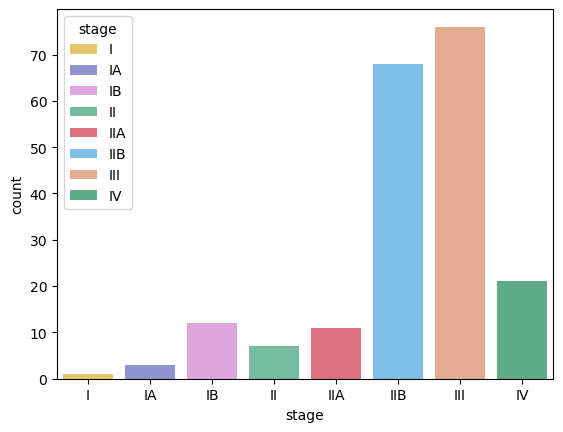

In [34]:
#bar plot to observe the stages
stage_colour = ['#f9d05b', '#858cdd', '#e79ce8', '#69c8a4', '#f05f71', '#6ec2f7', '#f3a683', '#52b788' ]
sns.countplot(x='stage', hue='stage', data=df, palette=stage_colour)#,legend=False)

Amongst the samples diagnosed with pancreatic cancer, a majority were in stages IIB and III. This would have implications on the generalisability when using a predictive model based on this. In order to minimize this, we will first reduce the number of stages the data has been stratified into. 

Cancer staging is dependent on 3 factors: 
1. Primary Tumour (T), refering to the size of the primary tumour. Where by classifications are: TX – Primary tumor cannot be assessed, T0 – No evidence of primary tumour, Tis – Carcinoma in situ, T1 – Tumour limited to pancreas, 2 cm or less in greater dimension, T2 – Tumour limited to the pancreas, more than 2 cm in greatest dimension, T3 – Tumour extends beyond the pancreas but without involvement of the celiac axis or the superior mesenteric artery, T4 – Tumour involves the celiac axis or the superior mesenteric artery (unresectable primary tumour)
2. Reigonal Lymph Nodes (N), refer to lymph nodes within the tumour reigon that are actively draining lymph fluid from the area. Classifications are: NX – Regional lymph nodes cannot be assessed, N0 – No regional lymph node metastasis, N1 – Regional lymph metastasis
3. Distant Metastasis (M), refer to if the cancer has spread to other parts of the body. Here there is only M0 – No distant metastasis and M1 – Distant metastasis.

Using these classifications, cancer staging is as such: 

In [37]:
# img = Image.open('Cancer_Staging.png')
# display(img)

From the image above, we see that stage IA and IB classification differs mostly between the size of the primary tumour. There are no nodes or metastatis present. This suggests that we can combine stages I, IA and IB from our dataset. However, stage IIA and IIB differ based on the reigonal lymph node presence. A cancer has progressed to stage IIB when N1 occurs, regardless of T classification. In this case, we will combine stage II and stage IIA, leaving stage IIB seperated. Stage III occurs when the tumour has progressed in size and stage IV is classified if the tumor has metastatized, regardless of any other factors. These two stage classifications are distinct and will not be changed. 

The data collected also does not include any stage 0 patients, as it is harder to detect and rarely sampled. Although it is useful in building a predictive model, we do not have the relevant data. Among the non PDAC diagnosis, there was one labelled to have eventually became PDAC. However we will not be able to include this as there is too few data points, and including it is likely to result in overfitting. 

Hence, **the final classifications for the stages are: Stage I, Stage II, Stage IIB, Stage III and Stage IV.**

Although this was done, the stages will not be used in the final model. Stage is a classifcation that comes after cancer diagnosis, hence it cannot be a predictior. However, the stages were regroups in hopes that more advanced models can determine differences between biomarkers at different stages. 

Ref: https://www.pancreaticcancer.net.au/patients-pancreatic-cancer/staging/ , https://www.sciencedirect.com/science/article/pii/S0748798320301165 , https://www.cancer.gov/about-cancer/diagnosis-staging/staging 

In [43]:
#re-grouping the stages
stage_grouped = {
    'I': 'Stage I',
    'IA': 'Stage I',
    'IB': 'Stage I',
    'II': 'Stage II',
    'IIA': 'Stage II',
    'IIB': 'Stage IIB',
    'III': 'Stage III',
    'IV': 'Stage IV'
}

# Apply the mapping
df['stage_new'] = df['stage'].map(stage_grouped)

# Confirm result
print("New stages:", df['stage_new'].value_counts())

New stages: stage_new
Stage III    76
Stage IIB    68
Stage IV     21
Stage II     18
Stage I      16
Name: count, dtype: int64


[Text(0.5, 0, 'Stages'), Text(0, 0.5, 'Count')]

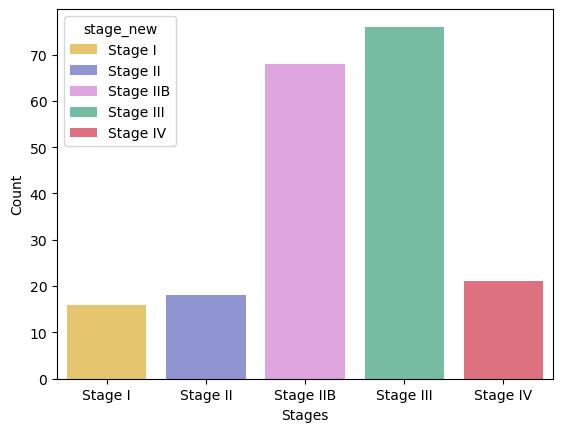

In [44]:
#barplot to visualize again
stagen_colour = ['#f9d05b', '#858cdd', '#e79ce8', '#69c8a4', '#f05f71']
sns.countplot(x='stage_new', hue='stage_new', data=df, palette=stagen_colour).set(xlabel='Stages', ylabel='Count')

Although there are still significantly more samples in stage IIB and III, it is slightly more balanced.

##### 1.1.2g Viewing the biomarker distributions

In [47]:
#viewing biomarkers by each of the diagnosis groups
biomarker_means = df.groupby('diagnosis')[['plasma_CA19_9', 'creatinine', 'LYVE1', 'REG1B', 'TFF1', 'REG1A']].mean()
biomarker_std = df.groupby('diagnosis')[['plasma_CA19_9', 'creatinine', 'LYVE1', 'REG1B', 'TFF1', 'REG1A']].std()
biomarker_means

,plasma_CA19_9,creatinine,LYVE1,REG1B,TFF1,REG1A
diagnosis,,,,,,
1,8.749569,0.797633,1.212887,41.327901,169.024140,227.871886
2,61.785741,0.847929,2.084612,64.174510,448.256897,547.458092
3,1476.154733,0.916281,5.788567,226.308587,1148.611527,1138.323721


In [48]:
biomarker_std = df.groupby('diagnosis')[['plasma_CA19_9', 'creatinine', 'LYVE1', 'REG1B', 'TFF1', 'REG1A']].std()
biomarker_std

,plasma_CA19_9,creatinine,LYVE1,REG1B,TFF1,REG1A
diagnosis,,,,,,
1,12.189355,0.559215,1.915867,61.853353,278.209891,288.272476
2,235.816534,0.615872,2.371503,116.065669,645.503449,1210.159890
3,3550.038158,0.723810,3.779988,277.196827,1425.590658,1871.810807


#### Data Completeness

In [50]:
print(df.isnull().sum())

sample_id                    0
patient_cohort               0
sample_origin                0
age                          0
sex                          0
diagnosis                    0
stage                      391
benign_sample_diagnosis    382
plasma_CA19_9              240
creatinine                   0
LYVE1                        0
REG1B                        0
TFF1                         0
REG1A                      284
Benign_New                   0
stage_new                  391
dtype: int64


Plasma CA19_9 and REG1A have 240 and 284 samples missing. From the original study this data was collected from, plasma_CA19_9 was collected from patient medical records, and from their blood tests - where available. Since this model is looking specifically at urinary biomarkers, this feature will not be used for the predictive model. 

As for REG1A, the original study uses REG1B as a replacement biomarker for REG1A. In other literature, REG1A and REG1B expressions are highly related, with expression levels being associated with one another, and used in place of one another. The study also suggested that REG1B is a better candidate than REG1A in detection of pancreatic cancer. As such, instead of imputing a large number of datapoints to fill in the 284 missing values, REG1A can also be excluded from the model.

#### Outliers and Duplicates

The biomarker data is explored in different ways to determine any outliers or distributions to be aware of. 

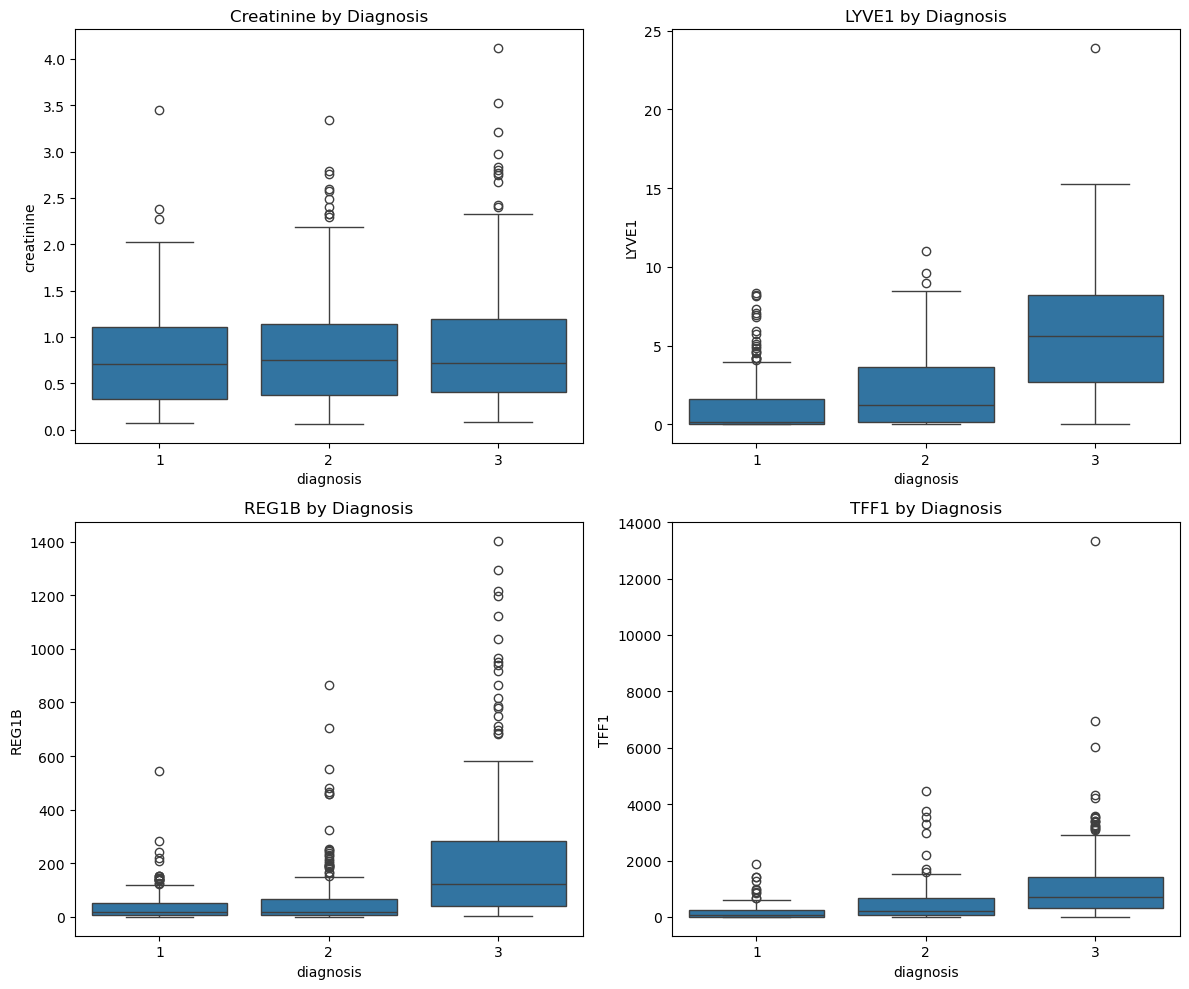

In [55]:
fig, axes = plt.subplots(2, 2, figsize=(12, 10))  # setting the plot

#each sns box plot indicates one biomarker, along with their distribution among each diagnosis group

sns.boxplot(ax=axes[0, 0], x='diagnosis', y='creatinine', data=df)
axes[0, 0].set_title('Creatinine by Diagnosis')

sns.boxplot(ax=axes[0, 1], x='diagnosis', y='LYVE1', data=df)
axes[0, 1].set_title('LYVE1 by Diagnosis')

sns.boxplot(ax=axes[1, 0], x='diagnosis', y='REG1B', data=df)
axes[1, 0].set_title('REG1B by Diagnosis')

sns.boxplot(ax=axes[1, 1], x='diagnosis', y='TFF1', data=df)
axes[1, 1].set_title('TFF1 by Diagnosis')

plt.tight_layout()
plt.show()

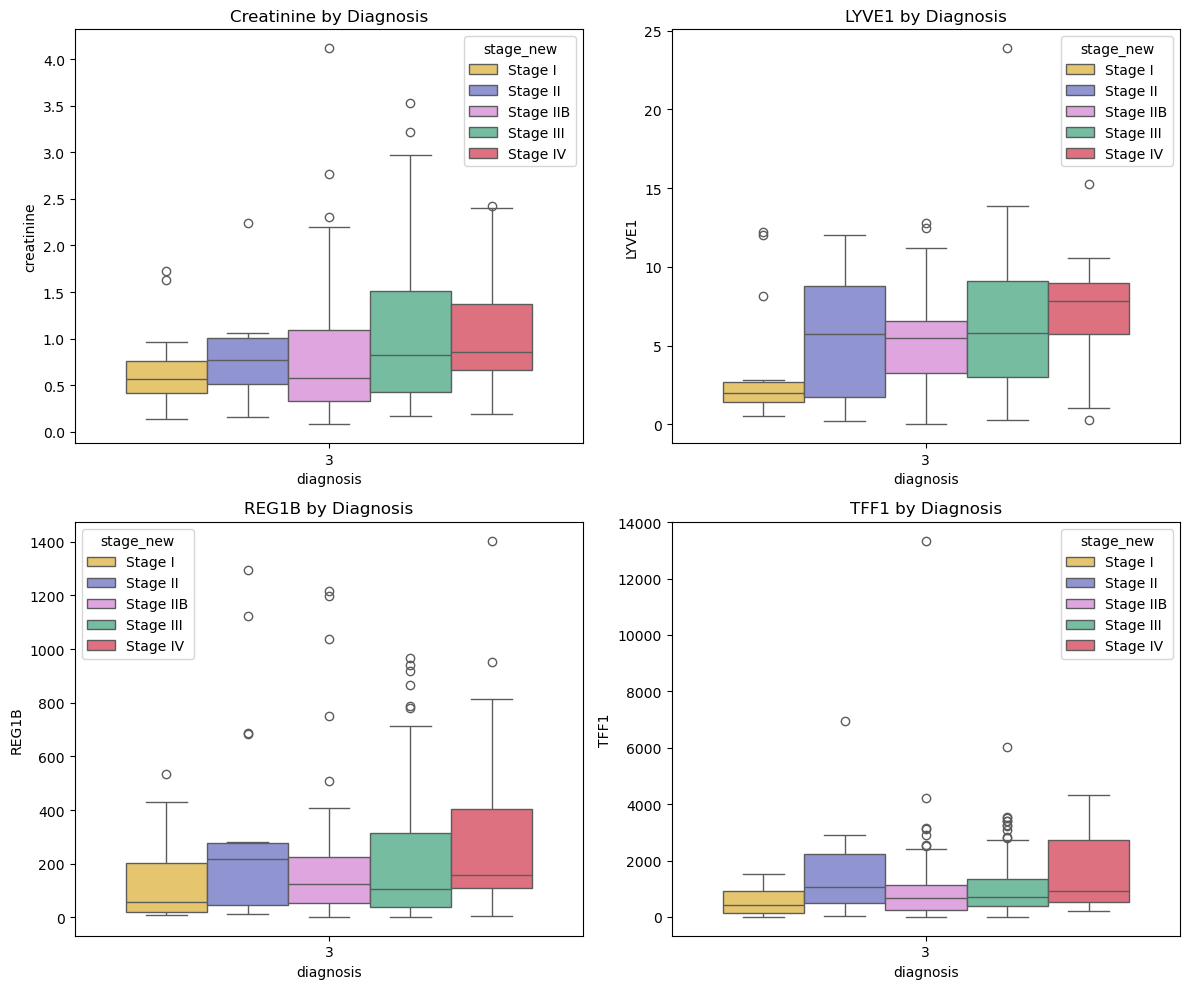

In [56]:
#to further stratify this, we view the outliers per stage

fig, axes = plt.subplots(2, 2, figsize=(12, 10))  # 2 rows, 2 columns

sns.boxplot(ax=axes[0, 0], x='diagnosis', y='creatinine', hue='stage_new', palette=stagen_colour, data=df[df['diagnosis'] == 3])
axes[0, 0].set_title('Creatinine by Diagnosis')

sns.boxplot(ax=axes[0, 1], x='diagnosis', y='LYVE1', hue='stage_new', palette=stagen_colour, data=df[df['diagnosis'] == 3])
axes[0, 1].set_title('LYVE1 by Diagnosis')

sns.boxplot(ax=axes[1, 0], x='diagnosis', y='REG1B', hue='stage_new', palette=stagen_colour, data=df[df['diagnosis'] == 3])
axes[1, 0].set_title('REG1B by Diagnosis')

sns.boxplot(ax=axes[1, 1], x='diagnosis', y='TFF1', hue='stage_new', palette=stagen_colour, data=df[df['diagnosis'] == 3])
axes[1, 1].set_title('TFF1 by Diagnosis')

plt.tight_layout()
plt.show()

We see that there are fewer outliers when statifying by the diganosis classes. As these are biomarker variables, and there has been no set highest possible for these biomarkers. The outliers will not be removed. However, we will look at the data skewness.

Text(0.5, 1.0, 'TFF1 Distribution: 5.158302')

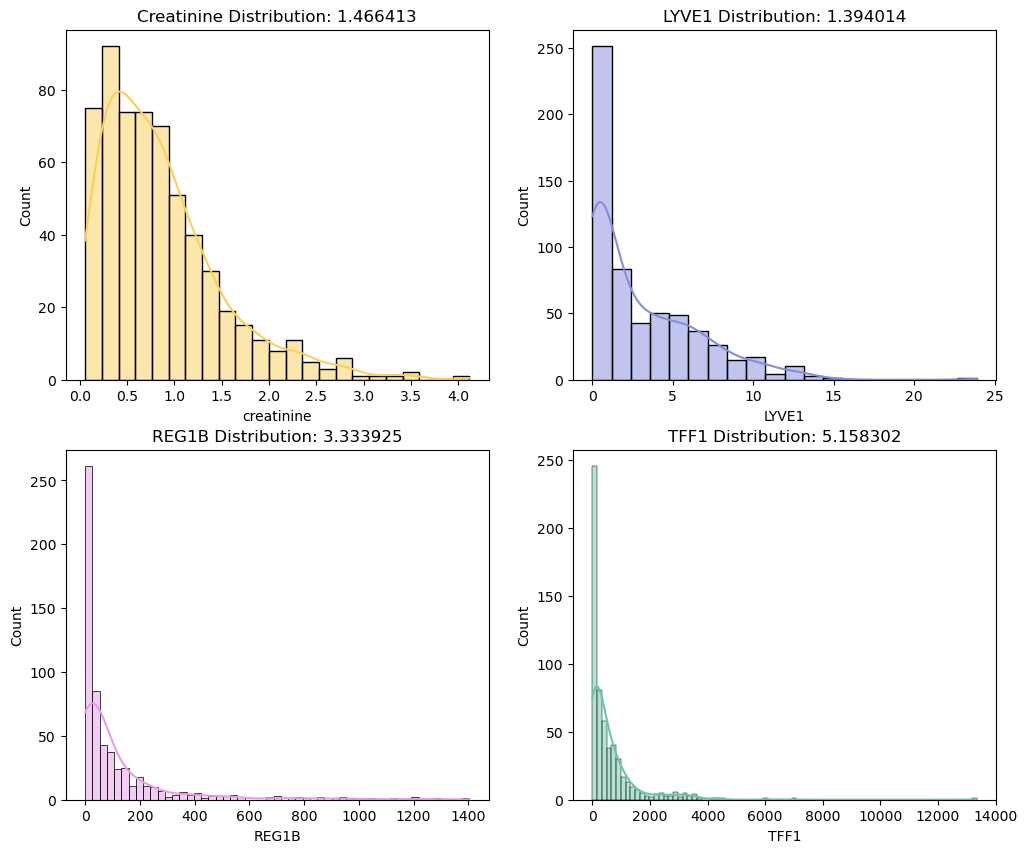

In [58]:
#these are plotted similar to above, with each plot representing a different biomarker
#this is a histogram which will help show the skew of the data

fig, axes = plt.subplots(2, 2, figsize=(12, 10)) 

sns.histplot(ax=axes[0, 0], data=df, x='creatinine', color='#f9d05b', kde=True)
axes[0, 0].set_title('Creatinine Distribution')
skew_val2 = df['creatinine'].dropna().skew()
axes[0, 0].set_title(f'Creatinine Distribution: {skew_val2:2f}')

sns.histplot(ax=axes[0, 1], data=df, x='LYVE1', color='#858cdd', kde=True)
axes[0, 1].set_title('LYVE1 Distribution')
skew_val2 = df['LYVE1'].dropna().skew()
axes[0, 1].set_title(f'LYVE1 Distribution: {skew_val2:2f}')

sns.histplot(ax=axes[1, 0], data=df, x='REG1B', color='#e79ce8', kde=True)
skew_val3 = df['REG1B'].dropna().skew()
axes[1, 0].set_title(f'REG1B Distribution: {skew_val3:2f}')

sns.histplot(ax=axes[1, 1], data=df, x='TFF1', color='#69c8a4', kde=True)
skew_val4 = df['TFF1'].dropna().skew()
axes[1, 1].set_title(f'TFF1 Distribution: {skew_val4:2f}')

All the data is right skewed, which is common in biological data, thus log transformation will be done to normalize it. 

However, prior to normalizing the data, we will firm normalize against creatinine. As explained in the readme, creatinine is often an indicator of urine concentration, and urinary biomarkers for other dieases often use creatinine normalization to standardize this variance in biological sampling. 

#### Transformation and Feature Engineering

In [62]:
#creating a new variable for the normalized values so as to not loose any data
df['LYVE1_Norm'] = df['LYVE1']/df['creatinine']
df['REG1B_Norm'] = df['REG1B']/df['creatinine']
df['TFF1_Norm'] = df['TFF1']/df['creatinine']

Now that this is done, we go back to log transforming the features:

In [64]:
#'creatinine', 'LYVE1', 'REG1B', 'TFF1'
df['Creatinine_Log'] = np.log(df['creatinine'])
df['LYVE1_Log'] = np.log(df['LYVE1'])
df['REG1B_Log'] = np.log(df['REG1B'])
df['TFF1_Log'] = np.log(df['TFF1'])
df #viewing the df to see if the new columns are put in properly

,sample_id,patient_cohort,sample_origin,age,sex,diagnosis,stage,benign_sample_diagnosis,plasma_CA19_9,creatinine,...,REG1A,Benign_New,stage_new,LYVE1_Norm,REG1B_Norm,TFF1_Norm,Creatinine_Log,LYVE1_Log,REG1B_Log,TFF1_Log
0,S1,Cohort1,BPTB,33,F,1,NaN,NaN,11.7,1.83222,...,1262.000,,NaN,0.487507,28.898735,357.098042,0.605528,-0.112923,3.969326,6.483539
1,S10,Cohort1,BPTB,81,F,1,NaN,NaN,NaN,0.97266,...,228.407,,NaN,2.094858,97.122355,215.376648,-0.027721,0.711765,4.548251,5.344668
2,S100,Cohort2,BPTB,51,M,1,NaN,NaN,7.0,0.78039,...,NaN,,NaN,0.186559,131.172875,590.910955,-0.247961,-1.926968,4.628555,6.133704
3,S101,Cohort2,BPTB,61,M,1,NaN,NaN,8.0,0.70122,...,NaN,,NaN,0.004000,86.390862,203.858989,-0.354934,-5.876395,4.103948,4.962495
4,S102,Cohort2,BPTB,62,M,1,NaN,NaN,9.0,0.21489,...,NaN,,NaN,0.004000,304.993252,191.204802,-1.537629,-7.059090,4.182661,3.715716
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
585,S549,Cohort2,BPTB,68,M,3,IV,NaN,NaN,0.52026,...,NaN,,Stage IV,13.566695,300.313305,1009.452966,-0.653427,1.954191,5.051400,6.263737
586,S558,Cohort2,BPTB,71,F,3,IV,NaN,NaN,0.85956,...,NaN,,Stage IV,9.704043,19.678673,286.131276,-0.151335,2.121208,2.828201,5.505116
587,S560,Cohort2,BPTB,63,M,3,IV,NaN,NaN,1.36851,...,NaN,,Stage IV,5.608075,211.690817,392.606557,0.313723,2.037930,5.668849,6.286531
588,S583,Cohort2,BPTB,75,F,3,IV,NaN,NaN,1.33458,...,NaN,,Stage IV,6.149333,154.303226,541.386054,0.288617,2.104960,5.327536,6.582749


We now view the distribution again to see if log transformation worked. 

Text(0.5, 1.0, 'TFF1 Distribution: -1.591281')

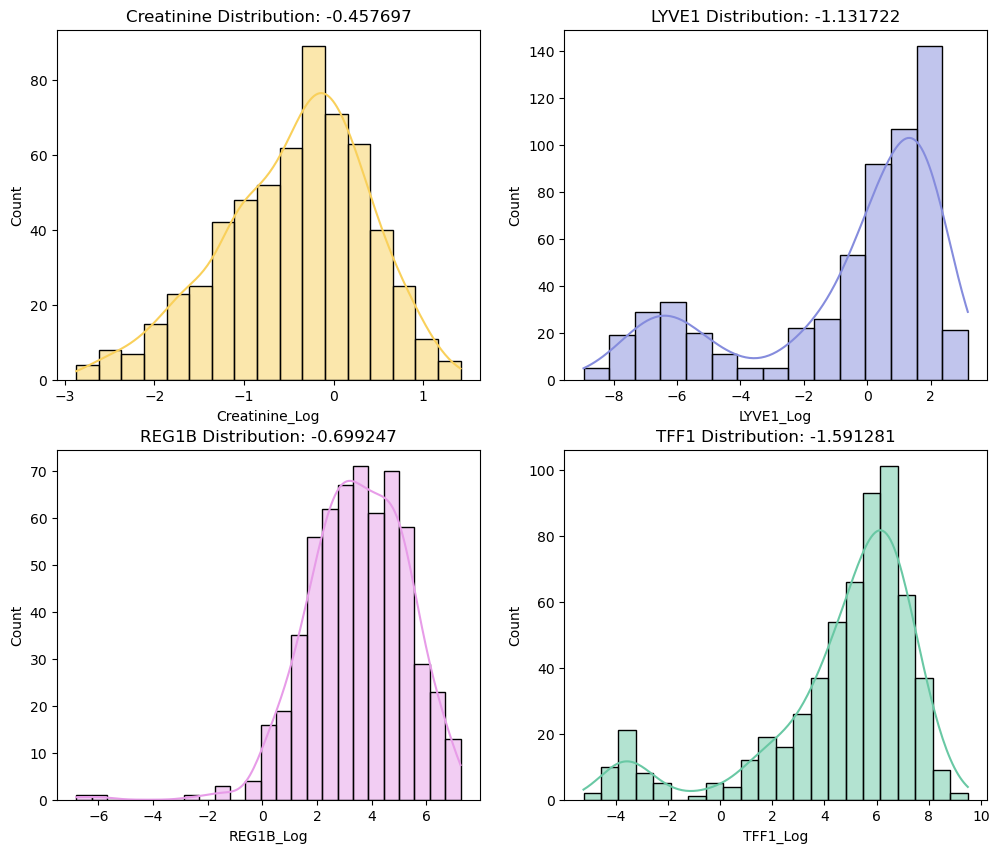

In [66]:
fig, axes = plt.subplots(2, 2, figsize=(12, 10))  

sns.histplot(ax=axes[0, 0], data=df, x='Creatinine_Log', color='#f9d05b', kde=True)
axes[0, 0].set_title('Creatinine Distribution')
skew_val2 = df['Creatinine_Log'].dropna().skew()
axes[0, 0].set_title(f'Creatinine Distribution: {skew_val2:2f}')

sns.histplot(ax=axes[0, 1], data=df, x='LYVE1_Log', color='#858cdd', kde=True)
axes[0, 1].set_title('LYVE1 Distribution')
skew_val2 = df['LYVE1_Log'].dropna().skew()
axes[0, 1].set_title(f'LYVE1 Distribution: {skew_val2:2f}')

sns.histplot(ax=axes[1, 0], data=df, x='REG1B_Log', color='#e79ce8', kde=True)
skew_val3 = df['REG1B_Log'].dropna().skew()
axes[1, 0].set_title(f'REG1B Distribution: {skew_val3:2f}')

sns.histplot(ax=axes[1, 1], data=df, x='TFF1_Log', color='#69c8a4', kde=True)
skew_val4 = df['TFF1_Log'].dropna().skew()
axes[1, 1].set_title(f'TFF1 Distribution: {skew_val4:2f}')

Here we see that all the variables now follow a more normal distribution.

#### Relationships

In order to understand what the model could potentially look like, we will explore the relationship between variables. 

In [70]:
#creating a for loop that calculates an anova statistical test 
#to determine if there is a statistically significant difference between each biomarker from each diagnosis class

biomarkers = ['creatinine', 'LYVE1', 'REG1B', 'TFF1']

for protein in biomarkers:
    grouped = [group[protein].values for name, group in df.groupby('diagnosis')]
    f_stat, p_value = f_oneway(*grouped)
    
    print(f'\n{protein}:')
    print(f'  F-statistic: {f_stat:.4f}')
    print(f'  p-value: {p_value:.4e}')
    
    if p_value < 0.01:
        print(f'  {protein} is significantly different between diagnosis groups')
    else:
        print(f'  {protein} is NOT significantly different between diagnosis groups')


creatinine:
  F-statistic: 1.6688
  p-value: 1.8936e-01
  creatinine is NOT significantly different between diagnosis groups

LYVE1:
  F-statistic: 145.0603
  p-value: 6.4174e-52
  LYVE1 is significantly different between diagnosis groups

REG1B:
  F-statistic: 62.6271
  p-value: 2.2229e-25
  REG1B is significantly different between diagnosis groups

TFF1:
  F-statistic: 57.6048
  p-value: 1.4365e-23
  TFF1 is significantly different between diagnosis groups


In [71]:
#the same is repeated for the transformed versions of the biomarkers

biomarkers = ['Creatinine_Log', 'LYVE1_Log', 'REG1B_Log', 'TFF1_Log']

for protein in biomarkers:
    grouped = [group[protein].values for name, group in df.groupby('diagnosis')]
    f_stat, p_value = f_oneway(*grouped)
    
    print(f'\n{protein}:')
    print(f'  F-statistic: {f_stat:.4f}')
    print(f'  p-value: {p_value:.4e}')
    
    if p_value < 0.01:
        print(f'  {protein} is significantly different between diagnosis groups')
    else:
        print(f'  {protein} is NOT significantly different between diagnosis groups')


Creatinine_Log:
  F-statistic: 1.2804
  p-value: 2.7869e-01
  Creatinine_Log is NOT significantly different between diagnosis groups

LYVE1_Log:
  F-statistic: 113.6332
  p-value: 1.9289e-42
  LYVE1_Log is significantly different between diagnosis groups

REG1B_Log:
  F-statistic: 77.7441
  p-value: 1.1166e-30
  REG1B_Log is significantly different between diagnosis groups

TFF1_Log:
  F-statistic: 61.7340
  p-value: 4.6446e-25
  TFF1_Log is significantly different between diagnosis groups


We see that LYVE1, REG1B and TFF1 are different between the classes, but creatinine is not. This gives us an insight into which values are likely to be significant to the classification model. 

### 1.2 Imputation and Balancing

No imputation and balancing will be done for this data because of the relative balance. However, it should be noted that the data is balanced because the original study had retrospectively picked out samples. It is possible that this has introduced a form of selection bias, or confounding variables into the dataset.

To summarize: 
1. Sample origin will be dropped
2. Changed diagnosis grouping 
3. Drop diagnosis grouping
4. Changed stage grouping
5. Drop stage group in model 
6. Drop plasma c19
7. Drop REG1A
8. Final features: age, sex, creatinine, LYVE1, REG1B, TFF1.

The rational for features are found in the readme

## 2. Model Development

Below is the development process for each of the models. A base model had been done for each model prior to conducting a grid search to optimize the parameters.  

In [78]:
#drop the unecessary columns
#create new df "working data frame, wdf" to prevent data loss
wdf = df.drop(['sample_id','patient_cohort','sample_origin','stage','benign_sample_diagnosis','Benign_New','plasma_CA19_9','creatinine','REG1B','LYVE1','TFF1','REG1A','stage_new','LYVE1_Norm','REG1B_Norm','TFF1_Norm'],axis=1)

#make gender into binary
wdf['sex'] = df['sex'].map({'M': 1, 'F': 0})

#changing diagnosis from 123 to 012 as xgboost requires it
wdf['diagnosis'] = df['diagnosis'].map({1: 0, 2: 1, 3: 2})
wdf

,age,sex,diagnosis,Creatinine_Log,LYVE1_Log,REG1B_Log,TFF1_Log
0,33,0,0,0.605528,-0.112923,3.969326,6.483539
1,81,0,0,-0.027721,0.711765,4.548251,5.344668
2,51,1,0,-0.247961,-1.926968,4.628555,6.133704
3,61,1,0,-0.354934,-5.876395,4.103948,4.962495
4,62,1,0,-1.537629,-7.059090,4.182661,3.715716
...,...,...,...,...,...,...,...
585,68,1,2,-0.653427,1.954191,5.051400,6.263737
586,71,0,2,-0.151335,2.121208,2.828201,5.505116
587,63,1,2,0.313723,2.037930,5.668849,6.286531
588,75,0,2,0.288617,2.104960,5.327536,6.582749


The data is first split into train and test variables. This will be what is used in all models to maintain a fair comparision. 

In [80]:
#splitting the data into train and test 
from sklearn.model_selection import train_test_split
X=wdf.drop('diagnosis',axis=1)
y=wdf['diagnosis']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [81]:
print(type(X_train), type(y_train))
print(X_train.shape, y_train.shape)

<class 'pandas.core.frame.DataFrame'> <class 'pandas.core.series.Series'>
(472, 6) (472,)


### 2.1 Baseline Model:Logistic Regression

In [83]:
#Gridsearch to determine the best parameters
param_gridLGR = {'C': [0.1, 1, 10],'penalty': ['l2'],'solver': ['lbfgs'],'multi_class': ['ovr','multinomial']}

In [84]:
gridLGR = GridSearchCV(LogisticRegression(max_iter=10000),param_gridLGR,cv=5,scoring='recall_macro',n_jobs=-1) 
#recall as the scoring criteria

In [85]:
#fitting the model into the grid search parameters
gridLGR.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=LogisticRegression(max_iter=10000), n_jobs=-1,
             param_grid={'C': [0.1, 1, 10],
                         'multi_class': ['ovr', 'multinomial'],
                         'penalty': ['l2'], 'solver': ['lbfgs']},
             scoring='recall_macro')

In [86]:
#which are the best parameters
bestLGR = gridLGR.best_estimator_

In [87]:
y_predLGR = bestLGR.predict(X_test)

In [88]:
accLGR = accuracy_score(y_test, y_predLGR ) * 100

In [89]:
recallLGR = recall_score(y_test, y_predLGR, labels=[2], average='macro') * 100

In [90]:
print("\nBest Log Regression Parameters:", gridLGR.best_params_)


Best Log Regression Parameters: {'C': 0.1, 'multi_class': 'ovr', 'penalty': 'l2', 'solver': 'lbfgs'}


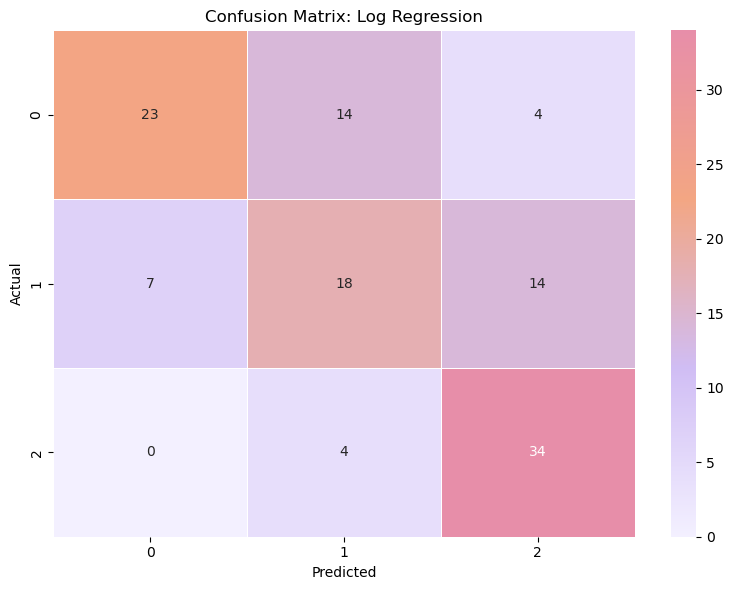

In [91]:
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test, y_predLGR), annot=True, fmt='d', cmap=custom_cmap, cbar=True, linewidths=0.5)
plt.title('Confusion Matrix: Log Regression')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()

In [92]:
print("\nClassification Report: Log Regression")
print(classification_report(y_test, y_predLGR))
print(f"Accuracy: {accLGR:.2f}%")
print(f"Recall for Pancreatic Cancer Prediction: {recallLGR:.2f}%")


Classification Report: Log Regression
              precision    recall  f1-score   support

           0       0.77      0.56      0.65        41
           1       0.50      0.46      0.48        39
           2       0.65      0.89      0.76        38

    accuracy                           0.64       118
   macro avg       0.64      0.64      0.63       118
weighted avg       0.64      0.64      0.63       118

Accuracy: 63.56%
Recall for Pancreatic Cancer Prediction: 89.47%


### 2.2 Advanced Model

#### Random Forest

In [95]:
#best parameters
param_gridRF = {'n_estimators': [50, 100, 200],
                'max_depth': [None, 10, 20, 30],
                'min_samples_split': [2, 5, 10],
                'min_samples_leaf': [1, 2, 4],
                'bootstrap': [True, False]}

In [96]:
RF = RandomForestClassifier(random_state=42)

In [97]:
grid_searchRF = GridSearchCV(
    RF,
    param_gridRF,
    cv=5,
    scoring='recall_macro', #recall as the important scoring criteria
    n_jobs=-1,
    verbose=1
)

In [98]:
grid_searchRF.fit(X_train, y_train)

Fitting 5 folds for each of 216 candidates, totalling 1080 fits


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'bootstrap': [True, False],
                         'max_depth': [None, 10, 20, 30],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [50, 100, 200]},
             scoring='recall_macro', verbose=1)

In [99]:
best_RF = grid_searchRF.best_estimator_

In [100]:
best_paramsRF = grid_searchRF.best_params_

In [101]:
y_predRF = best_RF.predict(X_test)

In [102]:
accRF = accuracy_score(y_test, y_predRF ) * 100

In [103]:
recallRF = recall_score(y_test, y_predRF, labels=[2], average='macro') * 100

In [104]:
print("\nBest Random Forest Parameters:", best_paramsRF)


Best Random Forest Parameters: {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 100}


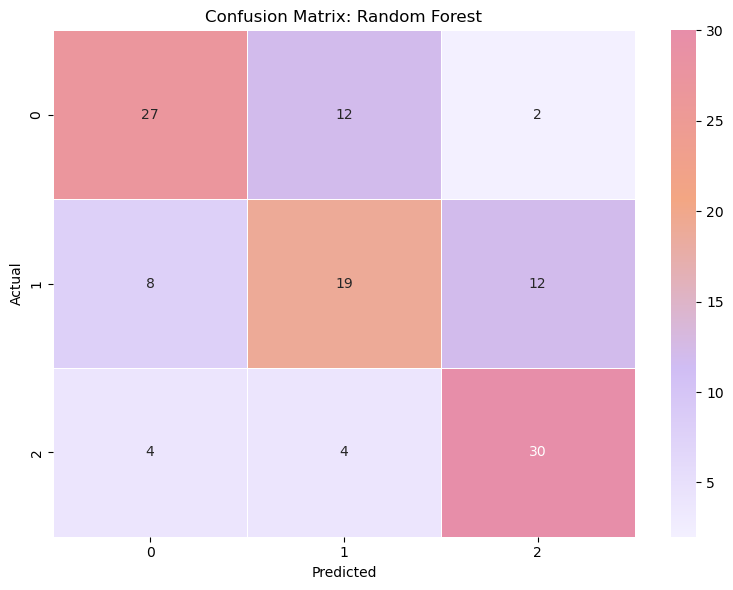

In [105]:
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test, y_predRF), annot=True, fmt='d', cmap=custom_cmap, cbar=True, linewidths=0.5)
plt.title('Confusion Matrix: Random Forest')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()

In [106]:
print("\nClassification Report: Log Regression")
print(classification_report(y_test, y_predRF))
print(f"Accuracy: {accRF:.2f}%")
print(f"Recall for Pancreatic Cancer Prediction: {recallRF:.2f}%")


Classification Report: Log Regression
              precision    recall  f1-score   support

           0       0.69      0.66      0.68        41
           1       0.54      0.49      0.51        39
           2       0.68      0.79      0.73        38

    accuracy                           0.64       118
   macro avg       0.64      0.65      0.64       118
weighted avg       0.64      0.64      0.64       118

Accuracy: 64.41%
Recall for Pancreatic Cancer Prediction: 78.95%


#### XGBoost

##### The grid search was run previously in another Jupyter notebook, however due to the length it took to run I will not re-run this code in this notebook. However i am using the best parameters which was obtained. 

Importantly, the XGBoost grid search attempted to focus on a distrinction between classes 1 and 2. Which is seen in this cell below:

In [110]:
# def recall_1_2(y_true, y_pred):
#     # Focus only on class 1 and 2
#     mask = (y_true == 1) | (y_true == 2)
#     y_true_filtered = y_true[mask]
#     y_pred_filtered = y_pred[mask]
#     return recall_score(y_true_filtered, y_pred_filtered, average='macro')  # average across class 1 and 2

# scorer = make_scorer(recall_1_2, greater_is_better=True)

The below cells form the standard grid search method

In [112]:
# gridXGB2 = GridSearchCV(
#     estimator=XGB,
#     param_grid=param_gridXGB,
#     scoring=scorer,
#     cv=5,
#     n_jobs=-1,
#     verbose=0  # set to 0 to silence most output
# )

In [113]:
# import warnings
# gridXGB2.fit(X_train, y_train)
# warnings.filterwarnings('ignore', category=UserWarning)

In [114]:
# print("Best parameters:", gridXGB2.best_params_)

In [115]:
# y_predXGB = gridXGB2.predict(X_test)

In [116]:
# accxgb = accuracy_score(y_test, y_predXGB)
# print("Confusion Matrix:")
# print(confusion_matrix(y_test, y_predXGB))
# print("\nClassification Report:")
# print(classification_report(y_test, y_predXGB))
# print("\nAccuracy:", accxgb) 

In [117]:
# BEST PARAMETERS: Best parameters: {'colsample_bytree': 0.8, 'gamma': 1, 'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 100, 'reg_alpha': 0, 'reg_lambda': 10, 'subsample': 1}

Here the XGBoost best parameters are implemented: 

In [119]:
XGB = XGBClassifier(
    colsample_bytree=0.8,
    gamma=1,
    learning_rate=0.1,
    max_depth=6,
    n_estimators=100,
    reg_alpha=0,
    reg_lambda=10,
    subsample=1
)

In [120]:
XGB.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=1, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=100,
              n_jobs=None, num_parallel_tree=None, ...)

In [121]:
y_predXGB = XGB.predict(X_test)

In [122]:
accXGB = accuracy_score(y_test, y_predXGB ) * 100

In [123]:
recallXGB = recall_score(y_test, y_predXGB, labels=[2], average='macro') * 100

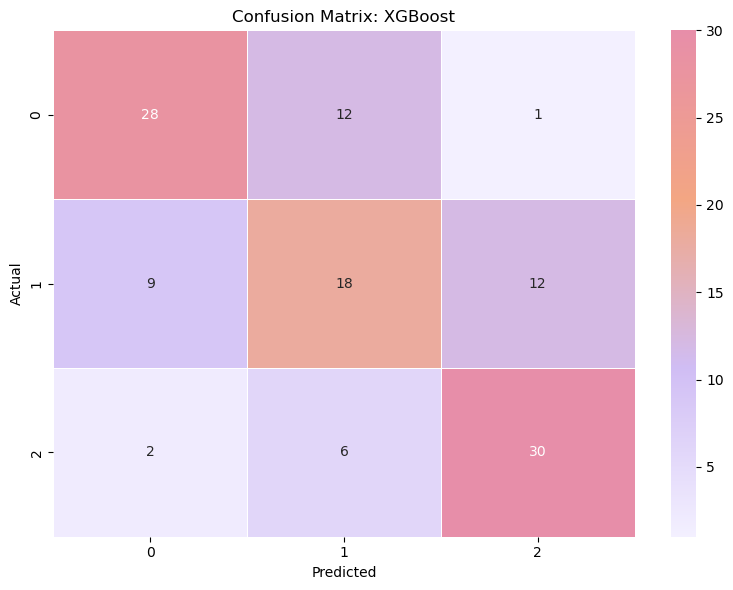

In [124]:
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test, y_predXGB), annot=True, fmt='d', cmap=custom_cmap, cbar=True, linewidths=0.5)
plt.title('Confusion Matrix: XGBoost')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()

In [125]:
print("\nClassification Report: Log Regression")
print(classification_report(y_test, y_predXGB))
print(f"Accuracy: {accXGB:.2f}%")
print(f"Recall for Pancreatic Cancer Prediction: {recallXGB:.2f}%")


Classification Report: Log Regression
              precision    recall  f1-score   support

           0       0.72      0.68      0.70        41
           1       0.50      0.46      0.48        39
           2       0.70      0.79      0.74        38

    accuracy                           0.64       118
   macro avg       0.64      0.64      0.64       118
weighted avg       0.64      0.64      0.64       118

Accuracy: 64.41%
Recall for Pancreatic Cancer Prediction: 78.95%


### 2.3 Comparison

In [127]:
#precision class 2
precisionXGB = precision_score(y_test, y_predXGB, labels=[2], average='macro') * 100
precisionRF = precision_score(y_test, y_predRF, labels=[2], average='macro') * 100
precisionLGR = precision_score(y_test, y_predLGR, labels=[2], average='macro') * 100

# F1-score for class 2
f1XGB = f1_score(y_test, y_predXGB, labels=[2], average='macro') * 100
f1RF = f1_score(y_test, y_predRF, labels=[2], average='macro') * 100
f1LGR = f1_score(y_test, y_predLGR, labels=[2], average='macro') * 100

compare = {
    'Model': ['XGB', 'RandomForest', 'LR'],
    'Accuracy': [accXGB, accRF, accLGR],
    'Recall': [recallXGB, recallRF, recallLGR],
    'Precision': [precisionXGB, precisionRF, precisionLGR],
    'F1-Score': [f1XGB, f1RF, f1LGR] 
}

comparePD = pd.DataFrame(compare)

comparePD.round(2)

,Model,Accuracy,Recall,Precision,F1-Score
0,XGB,64.41,78.95,69.77,74.07
1,RandomForest,64.41,78.95,68.18,73.17
2,LR,63.56,89.47,65.38,75.56


Here we see that while XGB and Random forest are slightly more accurate, the recall of log regression is far superior, and the overall F1 score is better. 

## 3. Explainable Analysis

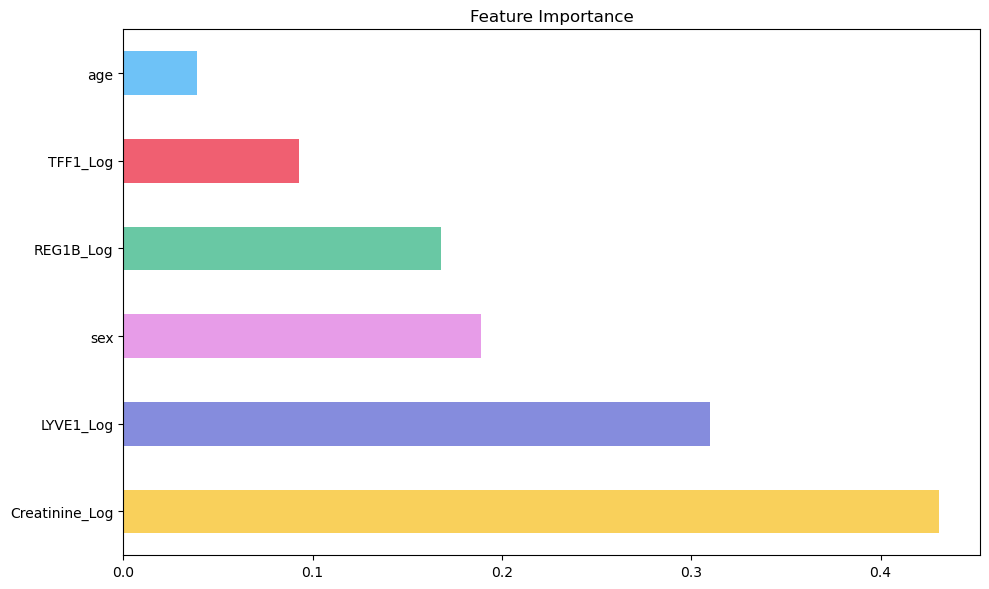

In [130]:
# After fitting your model:
coefs = bestLGR.coef_  # shape: (n_classes, n_features)

# Overall feature importance (mean absolute value across classes)
importances = np.mean(np.abs(coefs), axis=0)

# If you have feature names:
feature_names = X_train.columns  # Replace with your actual feature names
feat_importances = pd.Series(importances, index=feature_names)


barcolour = ['#f9d05b', '#858cdd', '#e79ce8', '#69c8a4', '#f05f71', '#6ec2f7']


plt.figure(figsize=(10, 6))
plt.title('Feature Importances from Log Regression')
feat_importances.nlargest(20).plot(kind='barh', title='Feature Importance', color = barcolour)
plt.tight_layout()
plt.show()

### LIME

In [132]:
# creating an instance of the lime tabular explainer
lime_explainer = lime_tabular.LimeTabularExplainer(training_data=np.array(X_train), feature_names=X_train.columns,
            class_names=['0', '1','2'], mode='classification')

In [133]:
# obtaining the explanation
explanation = lime_explainer.explain_instance(data_row=X_test.iloc[1], predict_fn=bestLGR.predict_proba, num_features=8)
# printing out the explanation
explanation.show_in_notebook(show_table = True, show_all = False)

/opt/anaconda3/lib/python3.12/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/opt/anaconda3/lib/python3.12/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/opt/anaconda3/lib/python3.12/site-packages/lime/lime_tabular.py:544: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by positio

### SHAP

In [135]:
explainer = shap.Explainer(bestLGR, X_train)

In [142]:
shap_values = explainer.shap_values(X_test)

class_idx = 2
shap_values_class = shap_values[:, :, class_idx]

shap.initjs()

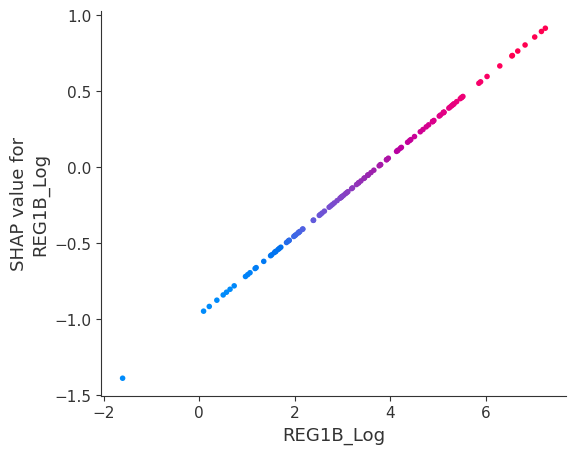

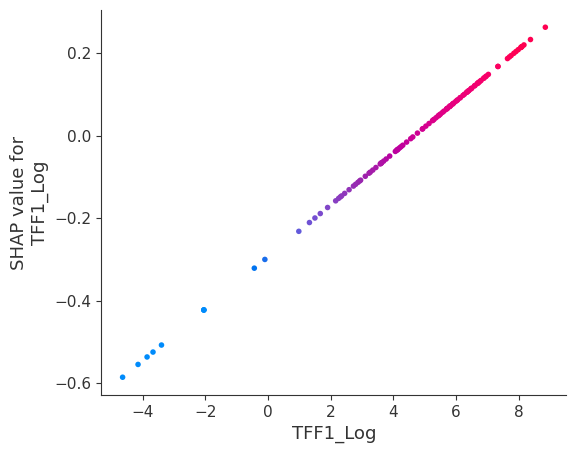

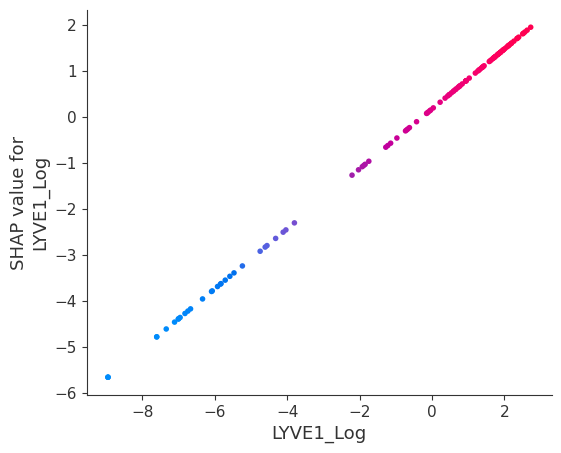

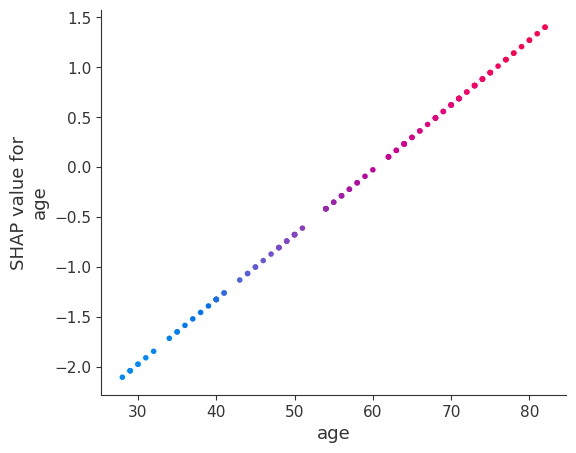

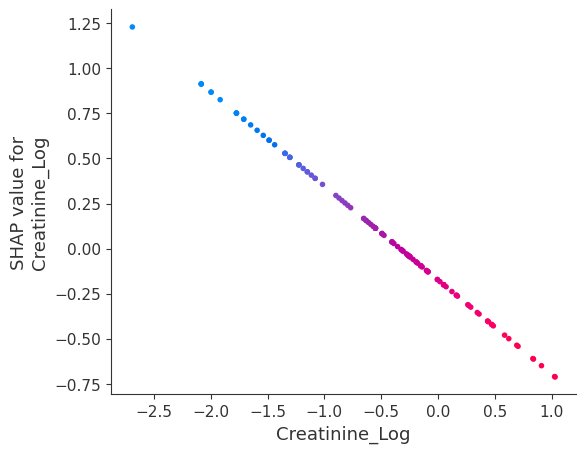

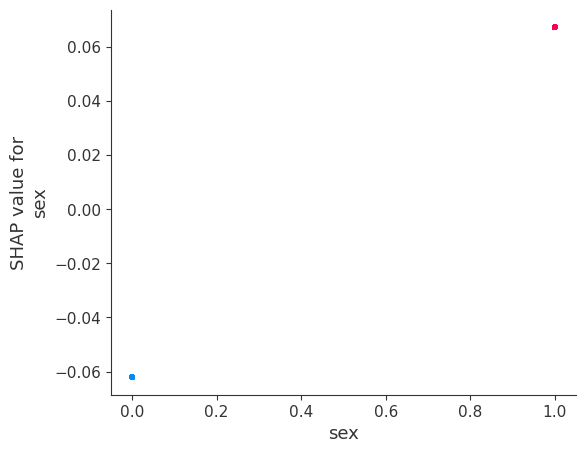

In [144]:
features = ['REG1B_Log', 'TFF1_Log', 'LYVE1_Log', 'age', 'Creatinine_Log', 'sex']

for feature in features:
    shap.dependence_plot(feature, shap_values_class, X_test, interaction_index=feature)
